In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muratkokludataset/acoustic-extinguisher-fire-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/acoustic-extinguisher-fire-dataset
License(s): CC0-1.0
  0% 0.00/621k [00:00<?, ?B/s]
100% 621k/621k [00:00<00:00, 664MB/s]


In [ ]:
!unzip acoustic-extinguisher-fire-dataset.zip

Archive:  acoustic-extinguisher-fire-dataset.zip
  inflating: Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.arff  
  inflating: Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx  
  inflating: Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset_Citation_Request.txt  


##Se carga el dataset en df

In [ ]:
import pandas as pd

# Ruta al archivo
file_path = '/content/Acoustic_Extinguisher_Fire_Dataset/Acoustic_Extinguisher_Fire_Dataset.xlsx'

# Cargar el archivo
df = pd.read_excel(file_path)

# Mostrar primeras filas
df.head()

,SIZE,FUEL,DISTANCE,DESIBEL,AIRFLOW,FREQUENCY,STATUS
0,1,gasoline,10,96,0.0,75,0
1,1,gasoline,10,96,0.0,72,1
2,1,gasoline,10,96,2.6,70,1
3,1,gasoline,10,96,3.2,68,1
4,1,gasoline,10,109,4.5,67,1


##Análisis exploratorio

In [ ]:
# Se crea una variable aparte con los datos para poder ser usada mas adelante.
df_LPG_binary = df.copy()

In [ ]:
df.info()
df.describe()
df['STATUS'].value_counts(normalize=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17442 entries, 0 to 17441
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SIZE       17442 non-null  int64  
 1   FUEL       17442 non-null  object 
 2   DISTANCE   17442 non-null  int64  
 3   DESIBEL    17442 non-null  int64  
 4   AIRFLOW    17442 non-null  float64
 5   FREQUENCY  17442 non-null  int64  
 6   STATUS     17442 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 954.0+ KB


,proportion
STATUS,
0,0.502179
1,0.497821


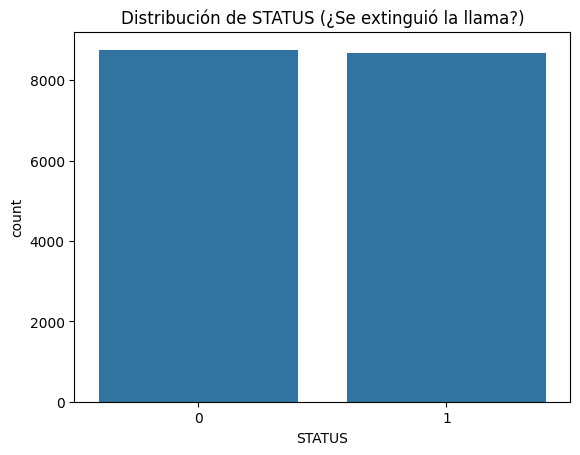

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='STATUS', data=df)
plt.title('Distribución de STATUS (¿Se extinguió la llama?)')
plt.show()

##Preprocesamiento

In [ ]:
df_encoded = pd.get_dummies(df, columns=["FUEL"], drop_first=True)

In [ ]:
X = df_encoded.drop("STATUS", axis=1)
y = df_encoded["STATUS"]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

##Entrenamiento de modelos

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# Diccionario para almacenar modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Entrenamiento y evaluación
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    resultados.append({
        "Modelo": nombre,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4)
    })

pd.DataFrame(resultados)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:33:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,Accuracy,F1-Score
0,Logistic Regression,0.8919,0.8919
1,KNN,0.9582,0.9582
2,Random Forest,0.9659,0.9659
3,XGBoost,0.9788,0.9788
4,MLPClassifier,0.9584,0.9584


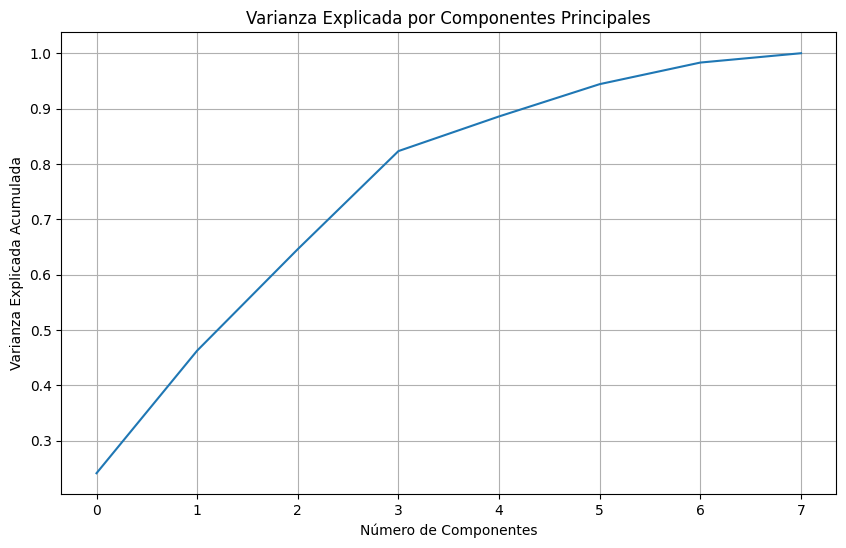

Varianza explicada con 4 componentes: 82.33%
Reducción de dimensionalidad: 8D → 4D (50.0% reducción)


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Aplicar PCA sin reducción para ver la varianza explicada
pca_full = PCA().fit(X_scaled)

# Graficar varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid()
plt.show()

# Seleccionamos el número de componentes donde la curva comienza a aplanarse
n_components = 4  # Ejemplo: punto donde ganamos poco añadiendo más componentes
print(f"Varianza explicada con {n_components} componentes: {np.cumsum(pca_full.explained_variance_ratio_)[n_components-1]:.2%}")

# Aplicar PCA con el número seleccionado de componentes
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Porcentaje de reducción
original_dim = X_scaled.shape[1]
reduced_dim = n_components
reduction_pct = (1 - reduced_dim/original_dim) * 100
print(f"Reducción de dimensionalidad: {original_dim}D → {reduced_dim}D ({reduction_pct:.1f}% reducción)")

In [ ]:
# Dividir datos transformados por PCA
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

# Evaluar los dos mejores modelos con PCA
best_models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

pca_results = []

for nombre, modelo in best_models.items():
    modelo.fit(X_train_pca, y_train)
    y_pred = modelo.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]

    pca_results.append({
        "Modelo": nombre,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "Componentes": n_components,
        "Varianza Explicada": f"{np.cumsum(pca.explained_variance_ratio_)[-1]:.1%}",
        "Reducción Dimensional": f"{reduction_pct:.1f}%"
    })

# Resultados en tabla
pca_results_df = pd.DataFrame(pca_results)
pca_results_df[['Modelo', 'Componentes', 'Varianza Explicada', 'Reducción Dimensional', 'Accuracy', 'F1-Score']]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:34:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Modelo,Componentes,Varianza Explicada,Reducción Dimensional,Accuracy,F1-Score
0,XGBoost,4,82.3%,50.0%,0.9603,0.9603
1,Random Forest,4,82.3%,50.0%,0.9568,0.9568


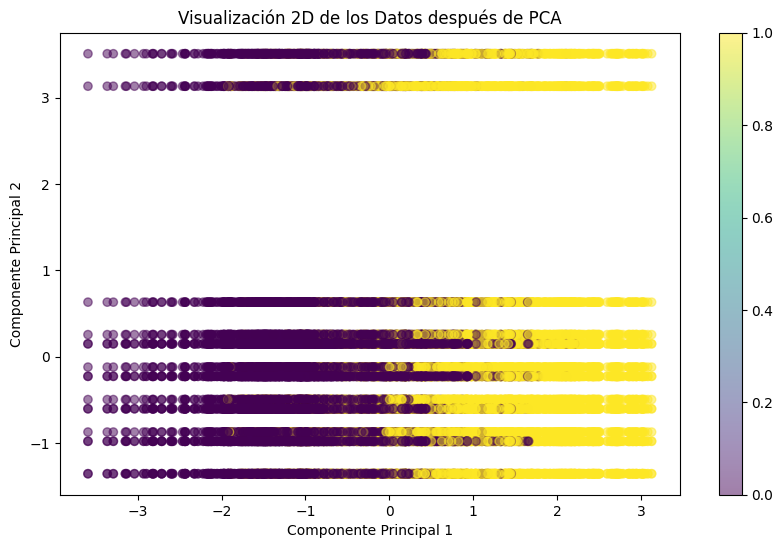

In [ ]:
# Visualización de datos en espacio reducido (2D)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y, alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Visualización 2D de los Datos después de PCA')
plt.colorbar()
plt.show()

In [ ]:
# Interpretación de componentes
components = pd.DataFrame(pca.components_, columns=X.columns)
print("Contribución de características a cada componente:")
print(components.abs().idxmax(axis=1))

Contribución de características a cada componente:
0         AIRFLOW
1        FUEL_lpg
2       FREQUENCY
3    FUEL_thinner
dtype: object


## Validación modificando el LPG a binario en otra columna

In [ ]:
# Crear nueva columna: 1 si SIZE es 6 o 7, 0 en caso contrario
df_LPG_binary['LPG_THROTTLE'] = df_LPG_binary['SIZE'].apply(lambda x: 1 if x in [6, 7] else 0)

In [ ]:
import numpy as np
df_LPG_binary['SIZE_CLEAN'] = df_LPG_binary['SIZE'].apply(lambda x: x if x in [1,2,3,4,5] else np.nan)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# Eliminar columnas originales que ya no usaremos
df_model = df_LPG_binary.copy()

# Codificar la variable categórica FUEL (one-hot)
df_model = pd.get_dummies(df_model, columns=['FUEL'], drop_first=True)

# Reemplazar valores NaN de SIZE_CLEAN por -1 para que el modelo lo interprete como valor fuera de escala
df_model['SIZE_CLEAN'] = df_model['SIZE_CLEAN'].fillna(-1)

# Separar features y target
X = df_model.drop(columns=['STATUS', 'SIZE'])  # 'SIZE' original ya no se usa
y = df_model['STATUS']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<Axes: xlabel='LPG_THROTTLE', ylabel='count'>

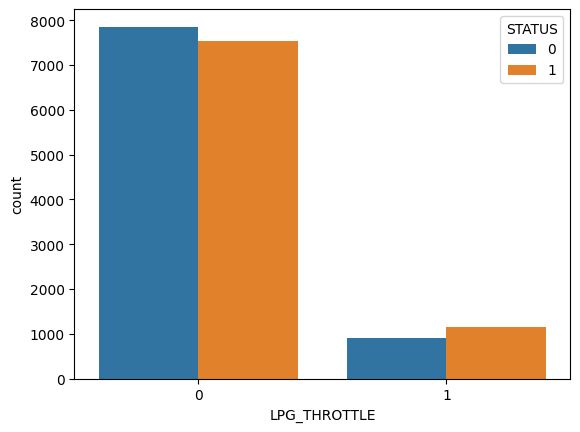

In [ ]:
sns.countplot(x='LPG_THROTTLE', hue='STATUS', data=df_LPG_binary)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)



In [ ]:
# Diccionario para almacenar modelos
modelos = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

# Entrenamiento y evaluación
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]
    resultados.append({
        "Modelo": nombre,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4)
    })

pd.DataFrame(resultados)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:09:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,Accuracy,F1-Score
0,Logistic Regression,0.8911,0.8911
1,KNN,0.9516,0.9516
2,Random Forest,0.9513,0.9513
3,XGBoost,0.9653,0.9653
4,MLPClassifier,0.9587,0.9587


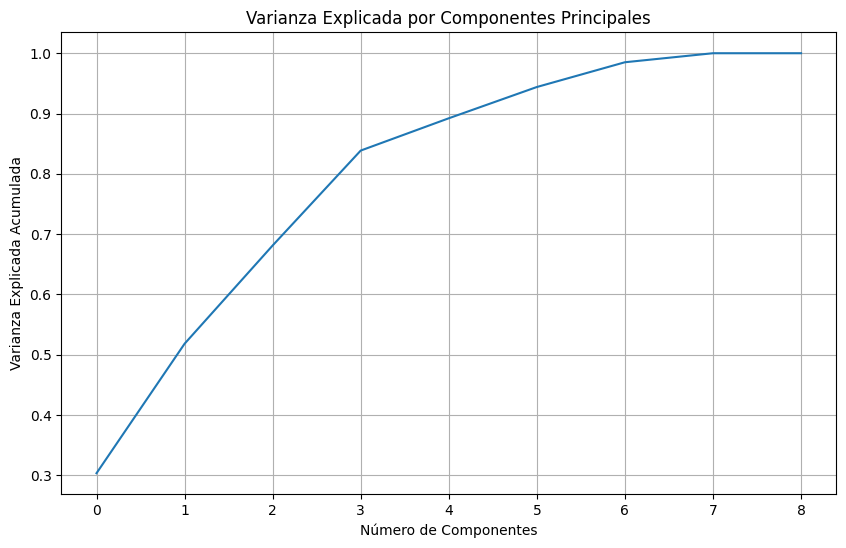

Varianza explicada con 4 componentes: 83.86%
Reducción de dimensionalidad: 9D → 4D (55.6% reducción)


In [ ]:
# Aplicar PCA sin reducción para ver la varianza explicada
pca_full = PCA().fit(X_scaled)

# Graficar varianza acumulada
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por Componentes Principales')
plt.grid()
plt.show()

# Seleccionamos el número de componentes donde la curva comienza a aplanarse
n_components = 4  # Ejemplo: punto donde ganamos poco añadiendo más componentes
print(f"Varianza explicada con {n_components} componentes: {np.cumsum(pca_full.explained_variance_ratio_)[n_components-1]:.2%}")

# Aplicar PCA con el número seleccionado de componentes
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Porcentaje de reducción
original_dim = X_scaled.shape[1]
reduced_dim = n_components
reduction_pct = (1 - reduced_dim/original_dim) * 100
print(f"Reducción de dimensionalidad: {original_dim}D → {reduced_dim}D ({reduction_pct:.1f}% reducción)")



In [ ]:
# Dividir datos transformados por PCA
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)



# Evaluar los dos mejores modelos con PCA
best_models = {
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

pca_results = []

for nombre, modelo in best_models.items():
    modelo.fit(X_train_pca, y_train)
    y_pred = modelo.predict(X_test_pca)

    acc = accuracy_score(y_test, y_pred)
    f1 = classification_report(y_test, y_pred, output_dict=True)["weighted avg"]["f1-score"]

    pca_results.append({
        "Modelo": nombre,
        "Accuracy": round(acc, 4),
        "F1-Score": round(f1, 4),
        "Componentes": n_components,
        "Varianza Explicada": f"{np.cumsum(pca.explained_variance_ratio_)[-1]:.1%}",
        "Reducción Dimensional": f"{reduction_pct:.1f}%"
    })

# Resultados en tabla
pca_results_df = pd.DataFrame(pca_results)
pca_results_df[['Modelo', 'Componentes', 'Varianza Explicada', 'Reducción Dimensional', 'Accuracy', 'F1-Score']]

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:47:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Modelo,Componentes,Varianza Explicada,Reducción Dimensional,Accuracy,F1-Score
0,XGBoost,4,83.9%,55.6%,0.9555,0.9555
1,Random Forest,4,83.9%,55.6%,0.9517,0.9517


In [ ]:
# Interpretación de componentes
components = pd.DataFrame(pca.components_, columns=X.columns)
print("Contribución de características a cada componente:")
print(components.abs().idxmax(axis=1))

Contribución de características a cada componente:
0    LPG_THROTTLE
1         AIRFLOW
2       FREQUENCY
3    FUEL_thinner
dtype: object
